In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../dataset_generation/")

import torch
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

plt.style.use("project_style.mplstyle")

import stats
import scipy.stats
from tqdm import tqdm
import analysis_tools as tools

In [3]:
samples = 1000
timesteps = 400
sequence  = ["square"]

bins = [16,16]

In [4]:
model_name = "al1_10_l2_0"
path = f"../models/{model_name}"
model, params = tools.load_model(path, device = "cpu", model_type = "RNN")

In [5]:
noise_scales = np.concatenate(([0], np.geomspace(1e-2, 1, 3)))
noise_scales

array([0.  , 0.01, 0.1 , 1.  ])

In [6]:
x0, r0, v0, c0 = tools.test_dataset(samples*[sequence[0]], timesteps*2, context = params["context"], 
                                    device = "cpu", trajectories = True)


In [7]:
xa, xb = (x0[0][:,:timesteps], x0[1][:,:timesteps]), (x0[0][:,timesteps:], x0[1][:,timesteps:])
xa[0].shape, xa[1].shape, xb[0].shape, xb[1].shape

(torch.Size([1000, 400, 8]),
 torch.Size([1000, 400, 2]),
 torch.Size([1000, 400, 8]),
 torch.Size([1000, 400, 2]))

In [8]:
def time_ratemaps(states, r, bins):
    # state.shape = (N, T, Nc)
    ratemaps = np.zeros((states.shape[1], states.shape[-1], *bins)).astype("float32")
    for i in range(states.shape[1]):
        ratemaps[i] = stats.ratemaps(states[None,:,i], r[None,:,i], [bins], smooth = True)  
    return ratemaps
        
def autocorr(x):
    z = np.zeros((len(x), len(x)))
    for i in tqdm(range(len(x))):
        for j in range(len(x)):
            z[i, j] = np.corrcoef(x[i], x[j])[1,0]
    return z

In [9]:
noisy_gs = []
noisy_ps = []

relu = torch.nn.ReLU()

for i in tqdm(range(len(noise_scales))):
    g_prev = None
    gs = []
    ps = []
    errors = []
    for x in (xa, xb):
        yhat, g, p, mu = model(x, g_prev = g_prev)
        noise = torch.normal(0, noise_scales[i], size = g[:,-1].shape)
        g_prev = relu(g[:, -1].detach().clone() + noise)
        g_ratemaps = time_ratemaps(g.detach().numpy(), x[1].detach().numpy(), bins)
        p_ratemaps = time_ratemaps(p.detach().numpy(), x[1].detach().numpy(), bins)
        gs.append(g_ratemaps.reshape((g_ratemaps.shape[0], -1)))
        ps.append(p_ratemaps.reshape((p_ratemaps.shape[0], -1)))

    noisy_gs.append(np.concatenate(gs, axis = 0))
    noisy_ps.append(np.concatenate(ps, axis = 0))

100%|██████████| 4/4 [02:16<00:00, 34.22s/it]


In [10]:
noisy_gs = np.array(noisy_gs)
noisy_ps = np.array(noisy_ps)

In [11]:
def autocorr(x):
    z = np.zeros((len(x), len(x)))
    for i in tqdm(range(len(x))):
        for j in range(len(x)):
            z[i, j] = np.corrcoef(x[i], x[j])[1,0]
    return z

In [12]:
g_corrs = np.zeros((noisy_gs.shape[0], noisy_gs.shape[1],noisy_gs.shape[1]))
p_corrs = np.zeros((noisy_ps.shape[0], noisy_ps.shape[1],noisy_ps.shape[1]))

In [13]:
for i in range(len(noise_scales)):
    g_corrs[i] = autocorr(noisy_gs[i])

100%|██████████| 800/800 [09:02<00:00,  1.47it/s]


In [14]:
for i in range(len(noise_scales)):
    p_corrs[i] = autocorr(noisy_ps[i])

100%|██████████| 800/800 [02:45<00:00,  4.83it/s]


In [15]:
p_min, g_min = np.amin(p_corrs), np.amin(g_corrs)

In [50]:
xticks = [0, 200, 400, 600, 800]

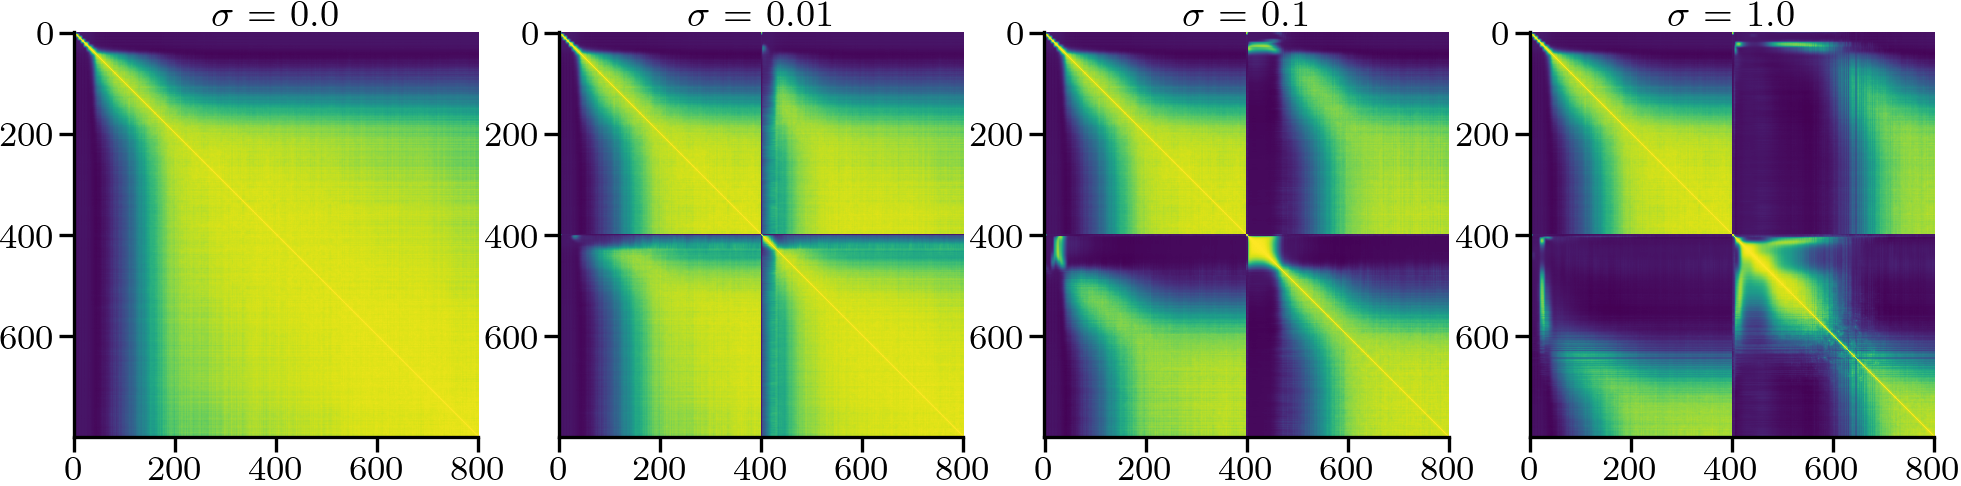

In [54]:
fig, ax = plt.subplots(1, len(noise_scales), figsize = (2*len(noise_scales), 2))
for i in range(len(noise_scales)):
    ax[i].imshow(p_corrs[i], vmin = p_min, vmax = 1)
    ax[i].set_title(f"$\sigma$ = {noise_scales[i]}")
    ax[i].set_xticks(xticks)
plt.savefig("./figures/attractor_p_correlations")

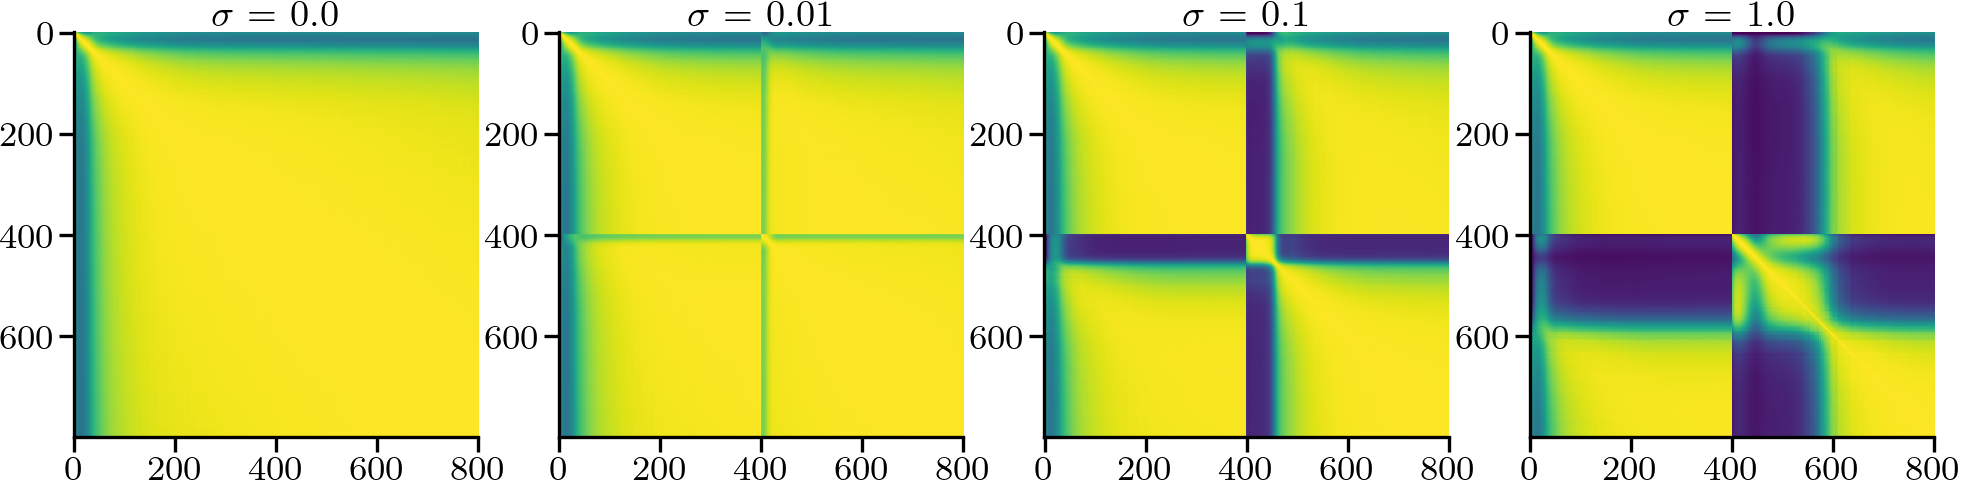

In [56]:
fig, ax = plt.subplots(1, len(noise_scales), figsize = (2*len(noise_scales), 2))
for i in range(len(noise_scales)):
    ax[i].imshow(g_corrs[i], vmin = g_min, vmax = 1)
    ax[i].set_title(f"$\sigma$ = {noise_scales[i]}")
    ax[i].set_xticks(xticks)
plt.savefig("./figures/attractor_g_correlations")

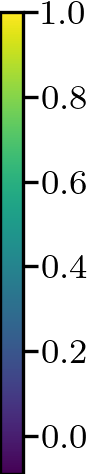

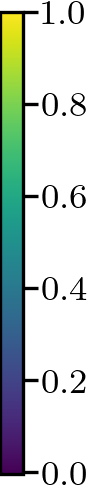

In [18]:
import matplotlib
fig, ax = plt.subplots(figsize=(0.1, 2))
# rewrite to for loop:
cmap = matplotlib.cm.viridis
norm = matplotlib.colors.Normalize(vmin=p_min, vmax=1)

cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm)
# fig.savefig("./figures/attractor_p_attractor_correlations_colorbar7")

fig, ax = plt.subplots(figsize=(0.1, 2))
norm = matplotlib.colors.Normalize(vmin=g_min, vmax=1)

cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm)
# fig.savefig("./figures/attractor_g_attractor_correlations_colorbar")

In [40]:
show_steps = [50, 399, 400, 500, 600, 799]

show_p = noisy_ps[-1].reshape(2*timesteps, 100, 16,16)
show_g = noisy_gs[-1].reshape(2*timesteps, 500, 16,16)

p_mask = np.argsort(np.amin(show_p[:timesteps], axis = (0, -2, -1)))

p_mask = np.argsort(np.amin(np.sum(show_p[timesteps], axis = (-2, -1)), axis = 0))[::-1][50:]

p_mask = np.argsort(np.sum(show_p[timesteps-1], axis = (-2, -1)))[::-1][5:]
g_mask = np.argsort(np.sum(show_g[timesteps-1], axis = (-2, -1)))[::-1][1:]


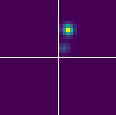

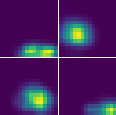

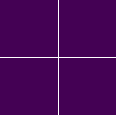

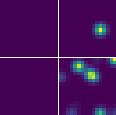

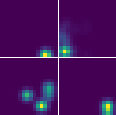

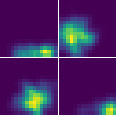

In [41]:
for t in show_steps:
    fig, ax = tools.plot_ensemble(show_p[t][p_mask], 2, pane_size= (0.25, 0.25))
    plt.subplots_adjust(wspace=0.025, hspace=0.02)
    fig.savefig(f"./figures/attractor_panel/p_{t}")

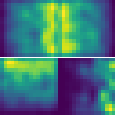

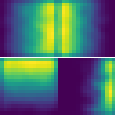

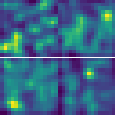

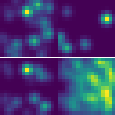

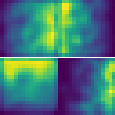

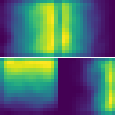

In [42]:
for t in show_steps:
    fig, ax = tools.plot_ensemble(show_g[:,g_mask][t], 2, pane_size=(0.25, 0.25))
    plt.subplots_adjust(wspace=0, hspace=0.01)
    fig.savefig(f"./figures/attractor_panel/g_{t}")

In [43]:
show_p = noisy_ps[0].reshape(2*timesteps, 100, 16,16)
show_g = noisy_gs[0].reshape(2*timesteps, 500, 16,16)

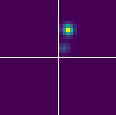

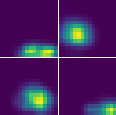

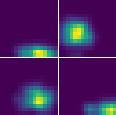

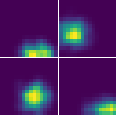

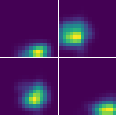

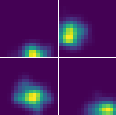

In [44]:
for t in show_steps:
    fig, ax = tools.plot_ensemble(show_p[t][p_mask], 2, pane_size= (0.25, 0.25))
    plt.subplots_adjust(wspace=0.025, hspace=0.02)
    fig.savefig(f"./figures/attractor_panel/p_{t}_no_noise")

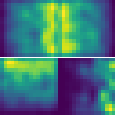

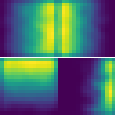

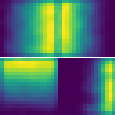

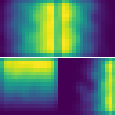

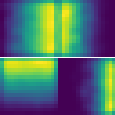

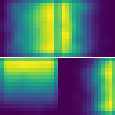

In [45]:
for t in show_steps:
    fig, ax = tools.plot_ensemble(show_g[:,g_mask][t], 2, pane_size=(0.25, 0.25))
    plt.subplots_adjust(wspace=0, hspace=0.01)
    fig.savefig(f"./figures/attractor_panel/g_{t}_no_noise")